# introduction

We have NR data from several groups in a few different formats. We need to bring them all together into a consistent format

In [1]:
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import h5py
import phenom
import os
import glob
import configparser
import scipy.optimize

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 432x288 with 0 Axes>

In [3]:
class SingleModeNRWaveform(object):
    def __init__(self, nrfile, ell, mm, npts, t1=None, t2=None):

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2

        self.get_lm_mode(self.nrfile, ell, mm, self.npts)


    def get_lm_mode(self, nrfile, ell, mm, npts):
        
        if '.h5' in nrfile:
            f = h5py.File(nrfile, 'r')

            self.eta = f.attrs['eta']
            # this try/except is here because the GTech waveforms
            # didn't put mass1, mass2 in their h5 files...
            # so I hope they correctly scaled to a total mass of 1...
            try:
                self.q = f.attrs['mass1']/f.attrs['mass2']
            except:
                self.q = phenom.q_from_eta(self.eta)
            

            amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
            amp_x = amp_tmp['X'][()]
            amp_y = amp_tmp['Y'][()]

            phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
            phase_x = phase_tmp['X'][()]
            phase_y = phase_tmp['Y'][()]

            f.close()
        else:
            # bam
            self.sim_dir = os.path.dirname(nrfile)
            self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
            # strict=False because of DuplicateSectionError
            config = configparser.ConfigParser(strict=False)

            config.read(self.bbh_file)
            mass1_tmp = float(config['metadata']['mass1'])
            mass2_tmp = float(config['metadata']['mass2'])
            self.initial_sep = float(config['metadata']['initial-separation'])

            if mass1_tmp >= mass2_tmp:
                mass1 = mass1_tmp
                mass2 = mass2_tmp
            else:
                mass1 = mass2_tmp
                mass2 = mass1_tmp


            self.mass1 = mass1
            self.mass2 = mass2
            self.mtot = self.mass1 + self.mass2
            self.q = self.mass1 / self.mass2
            self.eta = self.mass1 * self.mass2 / (self.mtot)**2.
            
            times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

            # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
            hlm = re_hlm - 1.j * im_hlm
            
            amp_x = times
            amp_y = np.abs(hlm)

            phase_x = times
            phase_y = np.unwrap(np.angle(hlm))
            
        # shift so that amp peak is at t=0 - will need to be more careful with HMs
        amp_peak_idx = amp_y.argmax()
        amp_peak_time = amp_x[amp_peak_idx]
        amp_x = amp_x - amp_peak_time
        phase_x = phase_x - amp_peak_time

        amp_i = IUS(amp_x, amp_y)
        phase_i = IUS(phase_x, phase_y)

        if self.t1 is None:
            self.t1 = max(amp_x[0], phase_x[0])
        if self.t2 is None:
            self.t2 = min(amp_x[-1], phase_x[-1])
            
        # t1,t2=-600,100

        common_times = np.linspace(self.t1, self.t2, npts)

        amplist = amp_i(common_times)
        phaselist = phase_i(common_times)

        self.times = common_times
        self.amp = amplist
        self.phi = phaselist
        # self.hlm["{0}, {1}".format(ell, mm)] = self.amp * np.exp(-1.j * self.phi)
        self.hlm = self.amp * np.exp(-1.j * self.phi)
        
    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)
        
class NRStrain(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time, t1=self.t1, t2=self.t2)
    
        self.eta = self.nrdata.eta
        self.q = float("{:.2f}".format(self.nrdata.q))
        
        amp = self.nrdata.amp
        phase = self.nrdata.phi
        
        max_idx_amp = np.argmax(amp)
        time_shift = self.nrdata.times[max_idx_amp]
        
        new_times = self.nrdata.times - time_shift
        
        self.times = np.linspace(self.t1, self.t2, self.npts_time)
        self.amp = IUS(new_times, amp)(self.times)
        self.phase = IUS(new_times, phase)(self.times)
        
        self.hlm = self.amp * np.exp(-1.j * self.phase)

        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)

In [4]:
nr_dict = {
    'q1': {
        'Res4': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5',
        'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res3.h5',
        'Res2': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res2.h5',
        },
    'q2': {
        'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5',
        'Res5': '/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res5.h5',
        'Res4': '/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res4.h5',
        },
    'q4': {
        'Res5': '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5',
        'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res3.h5',
        },
    'q5': {
        'Res4': '/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res4.h5',
        'Res5': '/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5',
        'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res3.h5',
        },
 'q10': {
    'Res4': '/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res4.h5',
    'Res5': '/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res5.h5',
    'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res3.h5',
    }
}

In [5]:
nr_dict

{'q1': {'Res4': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5',
  'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res3.h5',
  'Res2': '/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res2.h5'},
 'q2': {'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res3.h5',
  'Res5': '/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res5.h5',
  'Res4': '/Users/sebastian.khan/personal/data/SXS_BBH_0169_Res4.h5'},
 'q4': {'Res5': '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5',
  'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res3.h5'},
 'q5': {'Res4': '/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res4.h5',
  'Res5': '/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res5.h5',
  'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_0107_Res3.h5'},
 'q10': {'Res4': '/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res4.h5',
  'Res5': '/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res5.h5',
  'Res3': '/Users/sebastian.khan/personal/data/SXS_BBH_

In [6]:
nrs = NRStrain(nrfile=nr_dict['q1']['Res4'], ell=2, mm=2, npts_time=1000, t1=-500, t2=100)

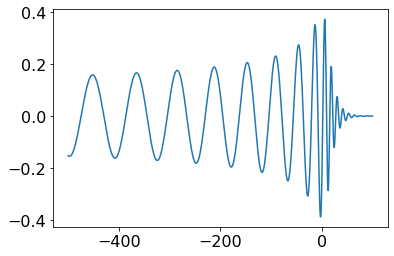

In [7]:
plt.figure()
plt.plot(nrs.times, nrs.hlm.real)

In [8]:
# https://stackoverflow.com/a/9888814/12840171
# because the BAM .bbh files use the same section name multiple times namely `[psi4t-data]`
# for different extraction radii then we have to customise how
# ConfigParser works. Normally ConfigParser will only return the final section but we want to keep them all.
# This bit of code adds an index to the end of all keys to make them unique.

# this doesn't work tho :(

from collections import OrderedDict

class multidict(OrderedDict):
    _unique = 0   # class variable

    def __setitem__(self, key, val):
        if isinstance(val, dict):
            self._unique += 1
            key += str(self._unique)
        OrderedDict.__setitem__(self, key, val)

In [9]:
def get_bam_psi4_mode(psi4_file, bbh_file):
    # bam
    # strict=False because of DuplicateSectionError
    config = configparser.ConfigParser(strict=False)
    # config = configparser.ConfigParser(defaults=None, strict=False)
    # config = configparser.ConfigParser(defaults=None, dict_type=multidict, strict=False)

    config.read(bbh_file)
    # print(config['metadata'])
    mass1_tmp = float(config['metadata']['mass1'])
    mass2_tmp = float(config['metadata']['mass2'])
    initial_sep = float(config['metadata']['initial-separation'])

    

    # enforce that mass1 is the primary 
    # however I don't do anything to flip the phase
    if mass1_tmp >= mass2_tmp:
        mass1 = mass1_tmp
        mass2 = mass2_tmp
    else:
        mass1 = mass2_tmp
        mass2 = mass1_tmp


    # mass1 = mass1
    # mass2 = mass2
    mtot = mass1 + mass2
    q = mass1 / mass2
    eta = mass1 * mass2 / (mtot)**2.

    times, re_hlm, im_hlm = np.loadtxt(psi4_file, unpack=True)

    # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
    hlm = re_hlm - 1.j * im_hlm
    
    amp_x = times
    amp_y = np.abs(hlm)

    phase_x = times
    phase_y = np.unwrap(np.angle(hlm))

    return amp_x, amp_y

In [10]:
# x, y = get_bam_psi4_mode(
#     psi4_file='/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q18a0a0c025_96_fine/q18a0a0c025_96_fine/Psi4ModeDecomp/psi3col.r9.l5.l2.m-2.gz',
#     bbh_file='/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q18a0a0c025_96_fine/q18a0a0c025_96_fine/q18a0a0c025_96_fine.bbh'
#     )

x, y = get_bam_psi4_mode(
    psi4_file='/Users/sebastian.khan/Desktop/q18a0a0c025_144/psi3col.r9.l4.l2.m-2.gz',
    bbh_file='/Users/sebastian.khan/Desktop/q18a0a0c025_144/q18a0a0c025_144.bbh'
    )

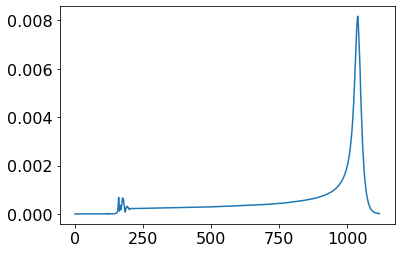

In [11]:
plt.figure()
plt.plot(x, y)

In [12]:
####
# code from https://git.ncsa.illinois.edu/elihu/Gravitational_Waveform_Extractor/-/blob/rhaas/POWER2/power.py
####

import math

#-----Function Definitions-----#

# use fixed frequency integration to integrate psi4 once
def FFIIntegrate(mp_psi4, f0):
    """
    Compute the integral of mmp_psi4 data using fixed frequency integration

    mp_psi4 = Weyl scalar result from simulation
    f0 = cutoff frequency
    return = news of the gravitational wave
    """
    #TODO: Check for uniform spacing in time
    t0 = mp_psi4[:, 0]
    list_len = len(t0)
    complexPsi = mp_psi4[:, 1]

    freq, psif = myFourierTransform(t0, complexPsi)
    hf = ffi(freq, psif, f0)

    time, h = myFourierTransformInverse(freq, hf, t0[0])
    hTable = np.column_stack((time, h))
    return hTable

#Convert modified psi4 to strain
def psi4ToStrain(mp_psi4, f0):
    """
    Convert the input mp_psi4 data to the strain of the gravitational wave

    mp_psi4 = Weyl scalar result from simulation
    f0 = cutoff frequency
    return = strain (h) of the gravitational wave
    """
    #TODO: Check for uniform spacing in time
    t0 = mp_psi4[:, 0]
    list_len = len(t0)
    complexPsi = mp_psi4[:, 1]+1.j*mp_psi4[:, 2]
    # complexPsi = mp_psi4[:, 1]-1.j*mp_psi4[:, 2]

    freq, psif = myFourierTransform(t0, complexPsi)
    dhf = ffi(freq, psif, f0)
    hf = ffi(freq, dhf, f0)

    time, h = myFourierTransformInverse(freq, hf, t0[0])
    hTable = np.column_stack((time, h))
    return hTable

#Fixed frequency integration
# See https://arxiv.org/abs/1508.07250 for method
def ffi(freq, data, f0):
    """
    Integrates the data according to the input frequency and cutoff frequency

    freq = fourier transform frequency
    data = input on which ffi is performed
    f0 = cutoff frequency
    """
    f1 = f0/(2*math.pi)
    fs = freq
    gs = data
    mask1 = (np.sign((fs/f1) - 1) + 1)/2.
    mask2 = (np.sign((-fs/f1) - 1) + 1)/2.
    mask = 1 - (1 - mask1) * (1 - mask2)
    fs2 = mask * fs + (1-mask) * f1 * np.sign(fs - np.finfo(float).eps)
    new_gs = gs/(2*math.pi*1.j*fs2)
    return new_gs

#Fourier Transform
def myFourierTransform(t0, complexPsi):
    """
    Transforms the complexPsi data to frequency space

    t0 = time data points
    complexPsi = data points of Psi to be transformed
    """
    psif = np.fft.fft(complexPsi, norm="ortho")
    # psif = np.fft.fft(complexPsi)
    l = len(complexPsi)
    n = int(math.floor(l/2.))
    newpsif = psif[l-n:]
    newpsif = np.append(newpsif, psif[:l-n])
    T = np.amin(np.diff(t0))*l
    freq = range(-n, l-n)/T
    return freq, newpsif

#Inverse Fourier Transform
def myFourierTransformInverse(freq, hf, t0):
    l = len(hf)
    n = int(math.floor(l/2.))
    newhf = hf[n:]
    newhf = np.append(newhf, hf[:n])
    amp = np.fft.ifft(newhf, norm="ortho")
    # amp = np.fft.ifft(newhf)
    df = np.amin(np.diff(freq))
    time = t0 + range(0, l)/(df*l)
    return time, amp

def angular_momentum(x, q, m, chi1, chi2, LInitNR):
    eta = q/(1.+q)**2
    m1 = (1.+math.sqrt(1.-4.*eta))/2.
    m2 = m - m1
    S1 = m1**2. * chi1
    S2 = m2**2. * chi2
    Sl = S1+S2
    Sigmal = S2/m2 - S1/m1
    DeltaM = m1 - m2
    mu = eta
    nu = eta
    GammaE = 0.5772156649;
    e4 = -(123671./5760.)+(9037.* math.pi**2.)/1536.+(896.*GammaE)/15.+(-(498449./3456.)+(3157.*math.pi**2.)/576.)*nu+(301. * nu**2.)/1728.+(77.*nu**3.)/31104.+(1792. *math.log(2.))/15.
    e5 = -55.13
    j4 = -(5./7.)*e4+64./35.
    j5 = -(2./3.)*e5-4988./945.-656./135. * eta;
    CapitalDelta = (1.-4.*eta)**0.5

    # Eq 4.7 here https://arxiv.org/pdf/1212.5520.pdf Bohe et al.
    # "Next-to-next-to-leading order spin-orbit effects in the near-zone metric
    # and precession equations of compact binaries"
    # Eq. 2.36 of https://arxiv.org/pdf/1111.5378.pdf "The First Law of Binary
    # Black Hole Mechanics in General Relativity and Post-Newtonian Theory"
    l = (eta/x**(1./2.)*(
        1. +
        x*(3./2. + 1./6.*eta) +
        x**2. *(27./8. - 19./8.*eta + 1./24.*eta**2.) +
        x**3. *(135./16. + (-6889./144. + 41./24. * math.pi**2.)*eta + 31./24.*eta**2. + 7./1296.*eta**3.) +
        x**4. *((2835./128.) + eta*j4 - (64.*eta*math.log(x)/3.))+
        x**5. *((15309./256.) + eta*j5 + ((9976./105.) + (1312.*eta/15.))*eta*math.log(x))+
        x**(3./2.)*(-(35./6.)*Sl - 5./2.*DeltaM* Sigmal) +
        x**(5./2.)*((-(77./8.) + 427./72.*eta)*Sl + DeltaM* (-(21./8.) + 35./12.*eta)*Sigmal) +
        x**(7./2.)*((-(405./16.) + 1101./16.*eta - 29./16.*eta**2.)*Sl + DeltaM*(-(81./16.) + 117./4.*eta - 15./16.*eta**2.)*Sigmal) +
        (1./2. + (m1 - m2)/2. - eta)* chi1**2. * x**2. +
        (1./2. + (m2 - m1)/2. - eta)* chi2**2. * x**2. +
        2.*eta*chi1*chi2*x**2. +
        ((13.*chi1**2.)/9. +
        (13.*CapitalDelta*chi1**2.)/9. -
        (55.*nu*chi1**2.)/9. -
        29./9.*CapitalDelta*nu*chi1**2. +
        (14.*nu**2. *chi1**2.)/9. +
        (7.*nu*chi1*chi2)/3. +
        17./18.* nu**2. * chi1 * chi2 +
        (13.* chi2**2.)/9. -
        (13.*CapitalDelta*chi2**2.)/9. -
        (55.*nu*chi2**2.)/9. +
        29./9.*CapitalDelta*nu*chi2**2. +
        (14.*nu**2. * chi2**2.)/9.)
        * x**3.))
    return l - LInitNR



def getCutoffFrequencyFromTwoPuncturesBBH(meta_filename, safety_factor=0.5):
    """
    Determine cutoff frequency of simulation

    meta_filename = path to TwoPunctures.bbh
    return = cutoff frequency
    """

    config = configparser.ConfigParser(strict=False)
    config.read(meta_filename)

    position1x = float(config['metadata']['initial-bh-position1x'])
    position1y = float(config['metadata']['initial-bh-position1y'])
    position1z = float(config['metadata']['initial-bh-position1z'])
    position2x = float(config['metadata']['initial-bh-position2x'])
    position2y = float(config['metadata']['initial-bh-position2y'])
    position2z = float(config['metadata']['initial-bh-position2z'])
    momentum1x = float(config['metadata']['initial-bh-momentum1x'])
    momentum1y = float(config['metadata']['initial-bh-momentum1y'])
    momentum1z = float(config['metadata']['initial-bh-momentum1z'])
    momentum2x = float(config['metadata']['initial-bh-momentum2x'])
    momentum2y = float(config['metadata']['initial-bh-momentum2y'])
    momentum2z = float(config['metadata']['initial-bh-momentum2z'])
    spin1x = float(config['metadata']['initial-bh-spin1x'])
    spin1y = float(config['metadata']['initial-bh-spin1y'])
    spin1z = float(config['metadata']['initial-bh-spin1z'])
    spin2x = float(config['metadata']['initial-bh-spin2x'])
    spin2y = float(config['metadata']['initial-bh-spin2y'])
    spin2z = float(config['metadata']['initial-bh-spin2z'])
    mass1 = float(config['metadata']['mass1'])
    mass2 = float(config['metadata']['mass2'])

    angularmomentum1x = position1y * momentum1z - momentum1z * momentum1y
    angularmomentum1y = position1z * momentum1x - momentum1x * momentum1z
    angularmomentum1z = position1x * momentum1y - momentum1y * momentum1x

    angularmomentum2x = position2y * momentum2z - momentum2z * momentum2y
    angularmomentum2y = position2z * momentum2x - momentum2x * momentum2z
    angularmomentum2z = position2x * momentum2y - momentum2y * momentum2x

    angularmomentumx = angularmomentum1x + angularmomentum2x
    angularmomentumy = angularmomentum1y + angularmomentum2y
    angularmomentumz = angularmomentum1z + angularmomentum2z

    LInitNR = math.sqrt(angularmomentumx**2 + angularmomentumy**2 + angularmomentumz**2)
    S1 = math.sqrt(spin1x**2 + spin1y**2 + spin1z**2)
    S2 = math.sqrt(spin2x**2 + spin2y**2 + spin2z**2)

    M = mass1+mass2
    q = mass1/mass2
    chi1 = S1/mass1**2
    chi2 = S2/mass2**2
    # .014 is the initial guess for cutoff frequency
    omOrbPN = scipy.optimize.fsolve(angular_momentum, .014, (q, M, chi1, chi2, LInitNR))[0]
    omOrbPN = omOrbPN**(3./2.)
    omGWPN = 2. * omOrbPN
    # omCutoff = 0.75 * omGWPN
    omCutoff = safety_factor * omGWPN
    return omCutoff


#####

In [13]:
getCutoffFrequencyFromTwoPuncturesBBH(meta_filename="/Users/sebastian.khan/Desktop/q18a0a0c025_144/q18a0a0c025_144.bbh")

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.07552855422383593

In [14]:
# times, re_hlm, im_hlm = np.loadtxt('/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q18a0a0c025_144/q18a0a0c025_144/Psi4ModeDecomp/psi3col.r9.l4.l2.m-2.gz', unpack=True)


# _, re_psi4, im_psi4 = np.loadtxt('/Users/sebastian.khan/Desktop/q18a0a0c025_144/psi3col.r9.l4.l2.m-2.gz', unpack=True)
# times, re_hlm, im_hlm = np.loadtxt('/Users/sebastian.khan/Desktop/q18a0a0c025_144/h3col.r9.l4.l2.m-2.gz', unpack=True)

_, re_psi4, im_psi4 = np.loadtxt('/Users/sebastian.khan/Desktop/q18a0a0c025_144/psi3col.r9.l4.l2.m2.gz', unpack=True)
times, re_hlm, im_hlm = np.loadtxt('/Users/sebastian.khan/Desktop/q18a0a0c025_144/h3col.r9.l4.l2.m2.gz', unpack=True)

In [15]:
plt.plot(times, np.unwrap(np.angle(re_psi4-1.j*im_psi4)), label='psi4')
plt.plot(times, np.unwrap(np.angle(re_hlm-1.j*im_hlm)), label='strain')
plt.legend()

In [16]:
plt.plot(times, re_psi4)
plt.plot(times, im_psi4)

In [17]:

plt.plot(times, re_hlm)
plt.plot(times, im_hlm)

In [18]:
news = FFIIntegrate(np.column_stack((times, re_psi4-1.j*im_psi4)), 0.07) # note the sign convention
strain = FFIIntegrate(news, 0.07)
strain[:,1] = strain[:,1]#.conj()

In [19]:
plt.plot(strain[:,0].real, strain[:,1].real)
plt.plot(strain[:,0].real, strain[:,1].imag)
plt.plot(strain[:,0].real, np.abs(strain[:,1]))

In [20]:
plt.plot(strain[:,0].real, np.abs(strain[:,1]))
plt.plot(times, np.abs(re_hlm-1.j*im_hlm))

In [21]:
plt.plot(strain[:,0].real, strain[:,1].real)
plt.plot(times, re_hlm)

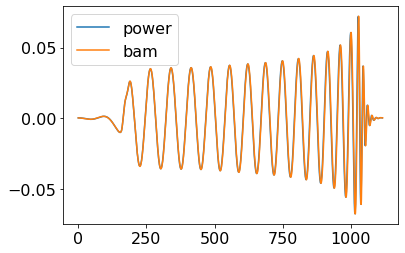

In [22]:
plt.plot(strain[:,0].real, strain[:,1].imag, label='power')
plt.plot(times, im_hlm, label='bam')
plt.legend()

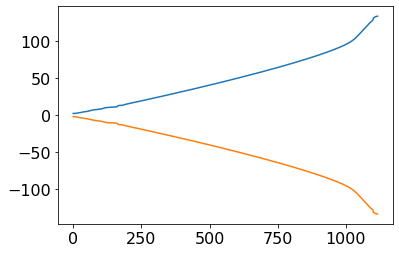

In [23]:
plt.plot(strain[:,0].real, np.unwrap(np.angle(strain[:,1])))

plt.plot(strain[:,0].real, np.unwrap(np.angle(re_hlm-1.j*im_hlm)))

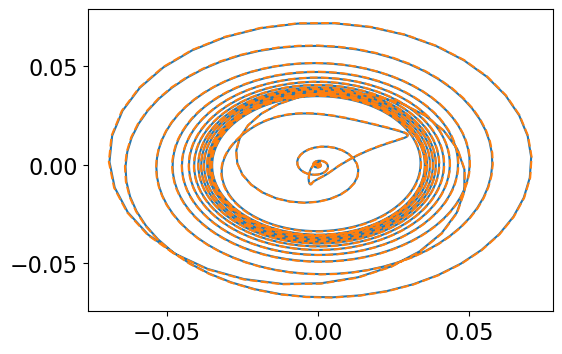

In [24]:
plt.figure(dpi=100)
plt.plot(strain[:,1].real, strain[:,1].imag)
plt.plot(re_hlm, im_hlm, ls='--')


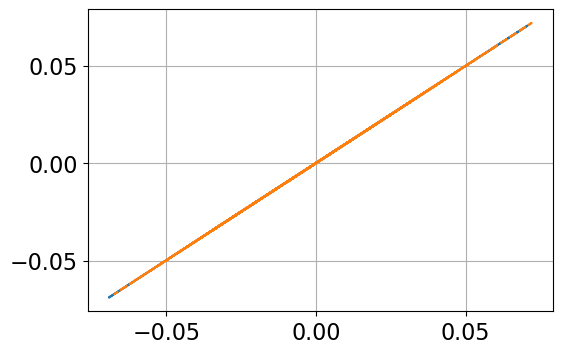

In [25]:
plt.figure(dpi=100)
plt.plot(re_hlm, strain[:,1].real)
plt.plot(im_hlm, strain[:,1].imag, ls='--')
plt.grid()

In [26]:
plt.figure(figsize=(10, 6), dpi=100)
f0s = np.linspace(0.01, 0.07, 10)
for f0 in f0s:
    news = FFIIntegrate(np.column_stack((times, re_psi4-1.j*im_psi4)), f0) # note the sign convention
    strain = FFIIntegrate(news, f0)


    plt.plot(strain[:,0].real, np.abs(strain[:,1]), label=f"{f0:.2f}")

plt.plot(times, np.abs(re_hlm-1.j*im_hlm), label='bam', c='k', ls='--')
# plt.xlim(10, 100)
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

0.06797569880145234


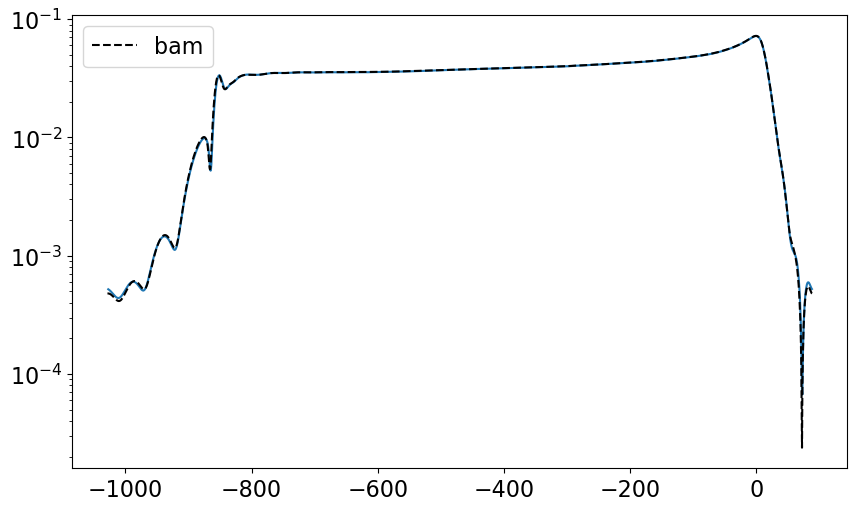

In [27]:
# f0=0.1132928#/2#/np.pi
f0=getCutoffFrequencyFromTwoPuncturesBBH(meta_filename="/Users/sebastian.khan/Desktop/q18a0a0c025_144/q18a0a0c025_144.bbh", safety_factor=0.45)
# f0=0.07
print(f0)
news = FFIIntegrate(np.column_stack((times, re_psi4-1.j*im_psi4)), f0) # note the sign convention
strain = FFIIntegrate(news, f0)

max_idx = np.argmax(np.abs(strain[:,1]))
max_t = strain[max_idx,0].real

plt.figure(figsize=(10,6), dpi=100)

plt.plot(strain[:,0].real-max_t, np.abs(strain[:,1]))

amp=np.abs(re_hlm-1.j*im_hlm)
max_idx = np.argmax(amp)
max_t = times[max_idx]
plt.plot(times-max_t, amp, label='bam', c='k', ls='--')

# plt.xlim(-100,100)
plt.yscale('log')
plt.legend()

In [28]:
s = strain[:,1].real - 1.j*strain[:,1].imag
# s = strain[:,1].conj() # SAME AS .conj()
h = re_hlm-1.j*im_hlm

In [29]:
s

array([-0.00038505-0.00034956j, -0.00038748-0.00034334j,
       -0.00039001-0.00033642j, ..., -0.00037782-0.00037823j,
       -0.00038066-0.00036497j, -0.00038277-0.00035564j])

In [30]:
h

array([-0.00029526-0.00037706j, -0.00029798-0.00037534j,
       -0.00030094-0.00037288j, ..., -0.00028799-0.00039219j,
       -0.0002907 -0.00038344j, -0.00029283-0.00037863j])

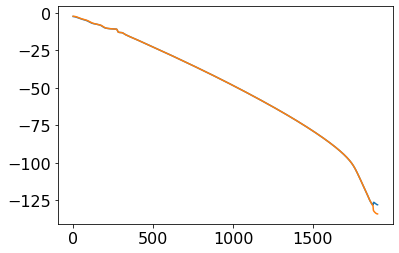

In [31]:
plt.plot(np.unwrap(np.angle(s)))
plt.plot(np.unwrap(np.angle(h)))

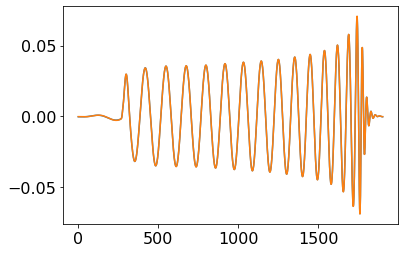

In [32]:
plt.plot(s.real)
plt.plot(h.real)

In [33]:
plt.plot(s.imag)
plt.plot(h.imag)